# Pneumonia Diagnosis from X-Ray Images Using Deep Learning
by Kevin Atkinson, Gideon Miles, and Alison Park

Our goal for this project is to create a Convolutional Neural Network capable of classifying X-Rays of patients with Pneumonia.

In [18]:
import os
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.io import decode_jpeg
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, LayerNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator

In [19]:
# get current directory, join with data paths
cwd = os.getcwd()
train_path = os.path.join(cwd, 'Data\\train')
test_path = os.path.join(cwd, 'Data\\test')
train_path

'C:\\Users\\Kevin\\Documents\\Flatiron\\Phase4_Project\\Data\\train'

In [20]:
# create lists of images within data folders
pneumonia_filenames = os.listdir(os.path.join(train_path, 'pneumonia'))
normal_filenames = os.listdir(os.path.join(train_path, 'normal'))
pneumonia_filenames[:5]

['BACTERIA-1008087-0001.jpeg',
 'BACTERIA-1025587-0001.jpeg',
 'BACTERIA-1027194-0001.jpeg',
 'BACTERIA-1033441-0001.jpeg',
 'BACTERIA-103798-0001.jpeg']

## Examples of Pneumonia

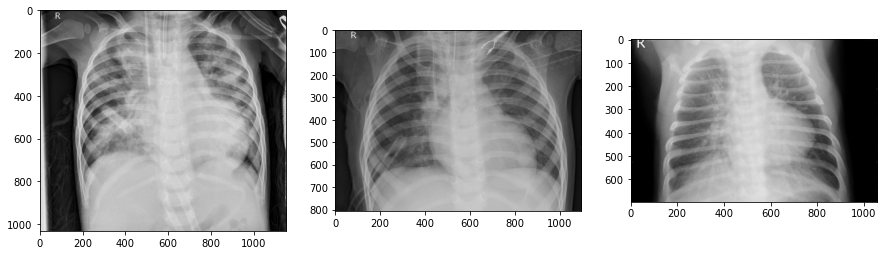

In [23]:
plt.figure(figsize=(15,15))
for i in range(3):
    filename = pneumonia_filenames[i]
    img_addr = train_path + '\\pneumonia\\' + filename
    img = Image.open(img_addr)
    ax = plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')

## Examples of Healthy Lungs

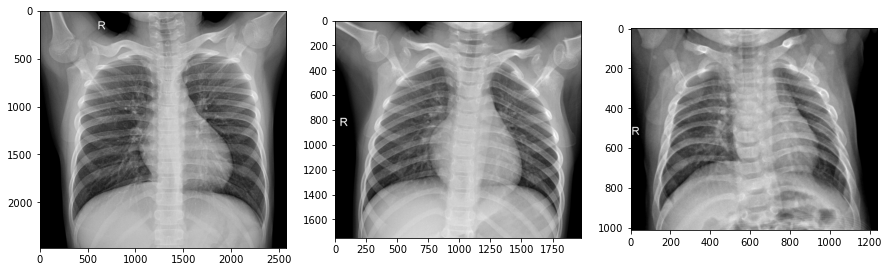

In [24]:
plt.figure(figsize=(15,15))
for i in range(3):
    filename = normal_filenames[i]
    img_addr = train_path + '\\normal\\' + filename
    img = Image.open(img_addr)
    ax = plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='gray')

## Data Augmentation

In order to create a model capable of adapting to X-Rays of varying brightness and orientation, we can use TensorFlow's ImageDataGenerator to load and augment files within our data folder.

Since we'll need to create multiple generators as we iterate through our models, we can create a function which will create these generators for us.

In [49]:
# This function creates image generators for train and validation to be used in our models
# We can call this function and alter its arguments in order to determine which model works best for our needs
def ImgGen(data_path, img_size=(128,128), batch_size=32, brightness=[0.8, 1.2], vsplit=0.2, rrange=10, seed=2023):
    train_datagen = ImageDataGenerator(validation_split=vsplit, rotation_range=rrange, fill_mode='nearest',
                                   brightness_range=brightness)
    train_gen = train_datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size,
                                                    class_mode='binary', color_mode='grayscale', subset='training',
                                                    shuffle=True, seed=seed)
    val_gen = train_datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size,
                                                    class_mode='binary', color_mode='grayscale', subset='validation',
                                                    shuffle=True, seed=seed)
    return train_gen, val_gen

In [50]:
train_gen1, val_gen1 = ImgGen(train_path)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


### Examples of Augmented Images, Labelled by Class

Here are examples of the output of the Image Data Generator

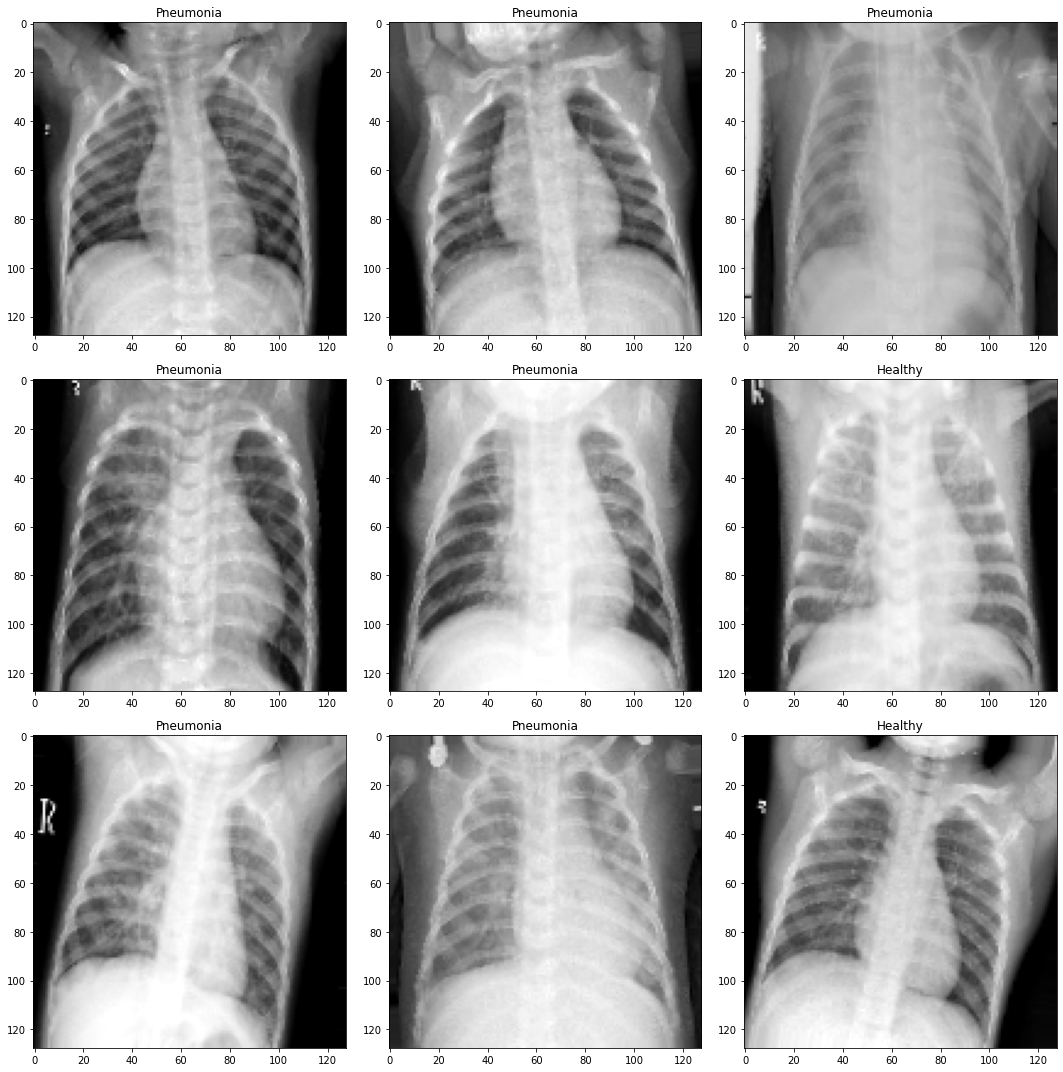

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
# Create list for labeling images
classes = ['Healthy', 'Pneumonia']
for i, ax in enumerate(axes.flat):
    img, label = train_gen1.next()
    for i in label[:9]:
        label = classes[int(i)]
    ax.imshow(img[0], cmap='gray')
    ax.set(title=f"{label}")
plt.tight_layout()
plt.show()

## Model 1

### Structure
For our first model we'll structure it in a fairly conventional way. We'll use three convolutional layers, with Max Pooling layers in between. We'll take the output of those layers into a Dense layer, and funnel the output of that layer into our model's output layer. Because this is a binary classification problem, we'll use a Sigmoid activation function in our output layer.

### Metrics
Although overall accuracy is an important metric, it's vital that we minimize false negatives. Determining a patient is healthy when they actually have Pneumonia is highly undesirable. For this reason we will be using Recall as our primary metric. However, we will also take into account precision and accuracy.

In [52]:
model1 = Sequential(name='Model1')

# input_shape must match what's provided to the image generator
model1.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(128,128,1))) 
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(Flatten())

model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision', 'accuracy'])
model1.summary()

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        73792     
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32113

In [56]:
results1 = model1.fit(train_gen1, epochs=10, workers=10, validation_data=val_gen1, validation_steps=100//train_gen1.batch_size)

Epoch 1/10
131/131 [==============================] - 74s 563ms/step - loss: 0.5151 - recall: 0.8902 - precision: 0.8848 - accuracy: 0.8326 - val_loss: 0.2294 - val_recall: 0.9054 - val_precision: 0.9853 - val_accuracy: 0.9167
Epoch 2/10
131/131 [==============================] - 72s 547ms/step - loss: 0.1956 - recall: 0.9475 - precision: 0.9515 - accuracy: 0.9252 - val_loss: 0.1324 - val_recall: 0.9730 - val_precision: 0.9474 - val_accuracy: 0.9375
Epoch 3/10
131/131 [==============================] - 71s 545ms/step - loss: 0.1703 - recall: 0.9578 - precision: 0.9517 - accuracy: 0.9326 - val_loss: 0.1589 - val_recall: 0.9848 - val_precision: 0.9286 - val_accuracy: 0.9375
Epoch 4/10
131/131 [==============================] - 72s 549ms/step - loss: 0.2126 - recall: 0.9459 - precision: 0.9423 - accuracy: 0.9169 - val_loss: 0.1216 - val_recall: 0.9600 - val_precision: 0.9863 - val_accuracy: 0.9583
Epoch 5/10
131/131 [==============================] - 77s 589ms/step - loss: 0.1673 - recall